In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [ ]:
df = pd.read_csv('news_sentiment_analysis(1).csv') # Use the filename from NLP Project Claude.ipynb
print(f"Data loaded: {len(df)} samples")
print(f"Label distribution:\n{df['sentiment'].value_counts()}\n")

Data loaded: 3500 samples
Label distribution:
sentiment
positive    2134
neutral      789
negative     577
Name: count, dtype: int64



In [ ]:
df

,Source,Author,Title,text,URL,Published At,sentiment,Type
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,"ST. GEORGE — Kaitlyn Larson, a first-year teac...",https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12T23:45:25+00:00,positive,Business
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,"Harare, Zimbabwe – Local businesses are grappl...",https://www.thezimbabwemail.com/business/busin...,2024-07-12T22:59:42+00:00,neutral,Business
2,4-traders,NaN,Musk donates to super pac working to elect Tru...,(marketscreener.com) Billionaire Elon Musk has...,https://www.marketscreener.com/business-leader...,2024-07-12T22:52:55+00:00,positive,Business
3,4-traders,NaN,US FTC issues warning to franchisors over unfa...,(marketscreener.com) A U.S. trade regulator on...,https://www.marketscreener.com/quote/stock/MCD...,2024-07-12T22:41:01+00:00,negative,Business
4,PLANET,NaN,Rooftop solar's dark side,4.5 million households in the U.S. have solar ...,https://www.npr.org/2024/07/12/1197961036/roof...,2024-07-12T22:28:19+00:00,positive,Business
...,...,...,...,...,...,...,...,...
3495,etfdailynews,MarketBeat News,"Arrow Electronics, Inc. (NYSE:ARW) Shares Purc...",QRG Capital Management Inc. increased its stak...,https://www.etfdailynews.com/2024/07/18/arrow-...,2024-07-18T14:36:45+00:00,positive,Technology
3496,etfdailynews,MarketBeat News,"3,120 Shares in NICE Ltd. (NASDAQ:NICE) Bought...",QRG Capital Management Inc. bought a new posit...,https://www.etfdailynews.com/2024/07/18/3120-s...,2024-07-18T14:36:44+00:00,positive,Technology
3497,etfdailynews,MarketBeat News,"QRG Capital Management Inc. Has $857,000 Stock...",QRG Capital Management Inc. boosted its stake ...,https://www.etfdailynews.com/2024/07/18/qrg-ca...,2024-07-18T14:36:43+00:00,positive,Technology
3498,finanznachrichten,NaN,Biotechnology Market: Surging Investments and ...,"WESTFORD, Mass., July 18, 2024 /PRNewswire/ --...",https://www.finanznachrichten.de/nachrichten-2...,2024-07-18T14:36:00+00:00,neutral,Technology


In [ ]:
def cleaning(text):
    """
    Performs text cleaning including:
    - Lowercasing
    - Removing URLs
    - Removing numbers
    - Removing punctuation
    """
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [ ]:
print("Applying data cleaning...")
df['cleaned_text'] = df['text'].apply(cleaning)
print("Cleaning complete. Sample cleaned text:")
print(df['cleaned_text'].iloc[0])


Applying data cleaning...
Cleaning complete. Sample cleaned text:
st george  kaitlyn larson a firstyear teacher at pine view high school recently received the best in state award for a business leadership course larsons students in grades  had the highest passing rate on the youscience exam during the spring and fall semesters of  the youscience exam is similar to final exams 


In [ ]:
class NewsSentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
def plot_confusion_matrix(true_labels, predictions, labels):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
X_text = df['cleaned_text'].tolist()
y = df['sentiment']

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
sentiment_classes = list(encoder.classes_)
print(f"Sentiment classes: {sentiment_classes}")
print(f"Encoded labels sample: {y_encoded[:5]}")


Sentiment classes: ['negative', 'neutral', 'positive']
Encoded labels sample: [2 1 2 0 2]


In [ ]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")


Training set size: 2800
Test set size: 700


In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

print(f"Tokenizing training data with {model_name} tokenizer...")
train_encodings = tokenizer(X_train_text, truncation=True, padding=True, max_length=128)
print(f"Tokenizing test data with {model_name} tokenizer...")
test_encodings = tokenizer(X_test_text, truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]


Tokenizing training data with distilbert-base-uncased tokenizer...
Tokenizing test data with distilbert-base-uncased tokenizer...


In [ ]:
train_dataset = NewsSentimentDataset(train_encodings, y_train)
test_dataset = NewsSentimentDataset(test_encodings, y_test)

num_labels = len(encoder.classes_)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)
print(f"\nDistilBERT model '{model_name}' loaded with {num_labels} classification heads.")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



DistilBERT model 'distilbert-base-uncased' loaded with 3 classification heads.


In [ ]:
training_args = TrainingArguments(
        output_dir='./results_distilbert',
        num_train_epochs=10,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs_distilbert',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none"
    )

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
print("Starting DistilBERT model training...")
trainer.train()
print("Training complete.")

print("\nEvaluating the model on the test set...")
results = trainer.evaluate()
print("Evaluation Results:")
print(results)


Starting DistilBERT model training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.483700,0.638336,0.772857,0.737143,0.785118,0.772857
2,0.420900,0.506429,0.840000,0.833572,0.837131,0.840000
3,0.181900,0.659667,0.864286,0.858340,0.864859,0.864286
4,0.154700,0.720113,0.872857,0.869875,0.870818,0.872857
5,0.059300,0.694793,0.895714,0.895361,0.895067,0.895714
6,0.000700,0.755602,0.897143,0.895631,0.895225,0.897143
7,0.015100,0.817185,0.898571,0.895874,0.898105,0.898571
8,0.000200,0.813103,0.892857,0.890694,0.890413,0.892857
9,0.000200,0.832226,0.894286,0.892925,0.892370,0.894286
10,0.000200,0.825174,0.892857,0.891352,0.890741,0.892857


Training complete.

Evaluating the model on the test set...


Evaluation Results:
{'eval_loss': 0.8171848654747009, 'eval_accuracy': 0.8985714285714286, 'eval_f1': 0.8958737074138753, 'eval_precision': 0.8981048857090072, 'eval_recall': 0.8985714285714286, 'eval_runtime': 2.4664, 'eval_samples_per_second': 283.816, 'eval_steps_per_second': 35.68, 'epoch': 10.0}



DistilBERT Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.69      0.77       115
     neutral       0.87      0.91      0.89       158
    positive       0.91      0.95      0.93       427

    accuracy                           0.90       700
   macro avg       0.89      0.85      0.86       700
weighted avg       0.90      0.90      0.90       700



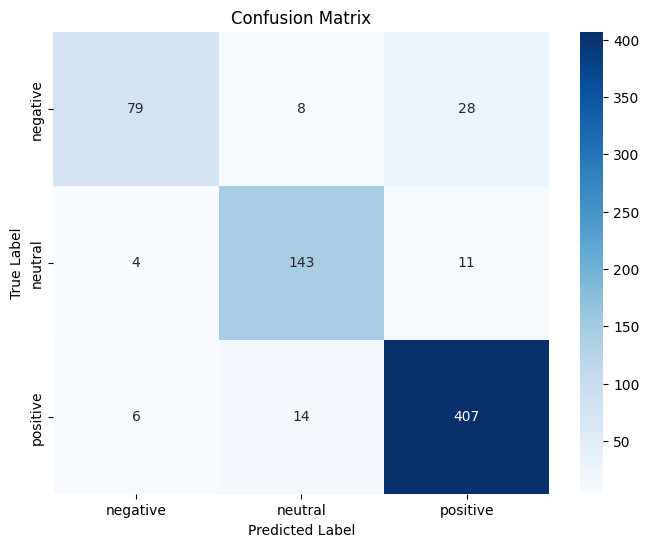


Model DistilBERT telah dilatih dan disimpan di './distilbert_sentiment_model_trainer'.


In [ ]:
predictions_output = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions_output.predictions, axis=1)

print("DistilBERT Classification Report:")
print(classification_report(y_test, predicted_labels, target_names=sentiment_classes))

plot_confusion_matrix(y_test, predicted_labels, sentiment_classes)

In [ ]:
predictions_output = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions_output.predictions, axis=1)
print("Sample Predictions:")
print(f"True labels: {y_test[:10].tolist()}")
print(f"Predicted labels: {predicted_labels[:10].tolist()}")
print(f"Decoded True labels: {encoder.inverse_transform(y_test[:10]).tolist()}")
print(f"Decoded Predicted labels: {encoder.inverse_transform(predicted_labels[:10]).tolist()}")



Sample Predictions:
True labels: [2, 0, 2, 2, 2, 2, 2, 2, 2, 1]
Predicted labels: [2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
Decoded True labels: ['positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral']
Decoded Predicted labels: ['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral']
